In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import re



In [2]:
pd.set_option('display.max_columns', 500)

#Plotting features
from itertools import cycle

plt.style.use("ggplot")
color_pal = plt.rcParams['axes.prop_cycle'].by_key()["color"]
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()["color"])

In [3]:
#dataset loading

tweets=pd.read_csv('./tweets.csv')
tweets.head()

,wordle_id,tweet_id,tweet_date,tweet_username,tweet_text
0,210,1482553374591660037,2022-01-16 03:20:43+00:00,bpszebes,Wordle 210 4/6\n\n⬛⬛🟨🟨⬛\n🟩⬛⬛⬛⬛\n🟩🟩🟨⬛⬛\n🟩🟩🟩🟩🟩
1,210,1482553387937898499,2022-01-16 03:20:46+00:00,cruisecoup,Wordle 210 4/6\n\n⬜⬜⬜⬜⬜\n🟩🟩🟨🟨⬜\n🟩🟩⬜🟩🟨\n🟩🟩🟩🟩🟩
2,210,1482553422276698113,2022-01-16 03:20:55+00:00,DestroVega,Wordle 210 4/6\n\n⬜⬜⬜🟨⬜\n⬜🟩⬜🟨⬜\n⬜🟩⬜🟨⬜\n🟩🟩🟩🟩🟩
3,210,1482553436910628866,2022-01-16 03:20:58+00:00,brenmardash,Wordle 210 3/6\n\n⬜⬜🟨⬜⬜\n🟨🟨⬜⬜⬜\n🟩🟩🟩🟩🟩
4,210,1482553445726908420,2022-01-16 03:21:00+00:00,KatieHowse2,Wordle 210 3/6\n\n⬛⬛🟨⬛⬛\n🟩🟩🟩⬛⬛\n🟩🟩🟩🟩🟩


In [4]:
print(tweets['tweet_text'][0])

Wordle 210 4/6

⬛⬛🟨🟨⬛
🟩⬛⬛⬛⬛
🟩🟩🟨⬛⬛
🟩🟩🟩🟩🟩


In [4]:
def process_tweets(tweets):
    tweets['tweet_datetime']=pd.to_datetime(tweets['tweet_date'])
    tweets['tweet_date']=tweets['tweet_datetime'].dt.date
    tweets['wordle_id']=tweets['tweet_text'].str[7:10].astype('int')
    tweets['n_attempts']=tweets['tweet_text'].str[11].astype('int')
    return tweets

tweets=process_tweets(tweets)

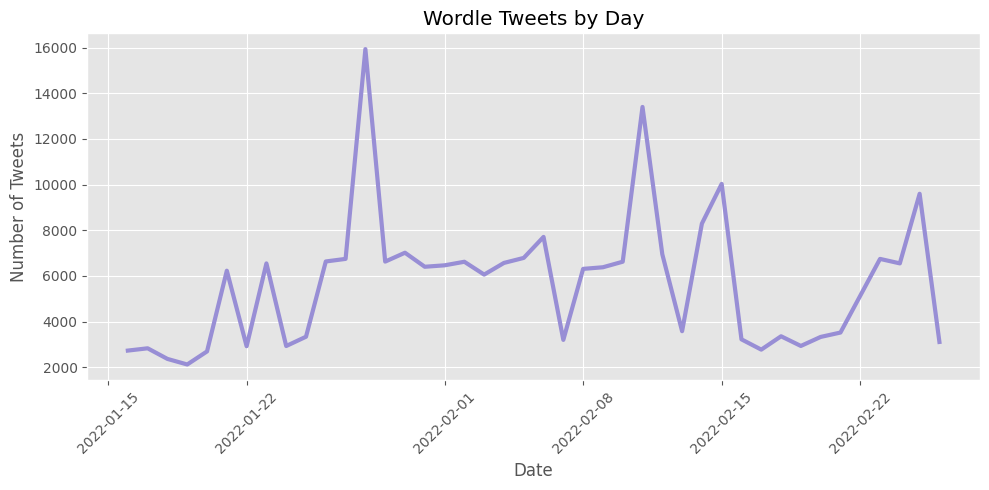

In [14]:
# Sort the data by date for proper time series visualization
tweets_by_date = tweets['tweet_date'].value_counts().sort_index()

tweets_by_date.plot(figsize=(10,5), title='Wordle Tweets by Day',
                   color=color_pal[2], lw=3)
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Number of Attempts

In [5]:
tweets.groupby('wordle_id')['n_attempts'].value_counts() \
    .unstack() \
    .style.background_gradient(axis=1)

n_attempts,2,3,4,5,6
wordle_id,,,,,
210,222,897,1064,489,165
211,196,903,1016,564,215
212,191,787,820,413,188
213,51,260,630,697,481
214,383,1012,823,363,122
215,246,877,1017,579,224
216,461,1952,2078,1199,415
217,102,566,1031,843,418
218,170,1009,1384,730,187


## How many attempts to solve 

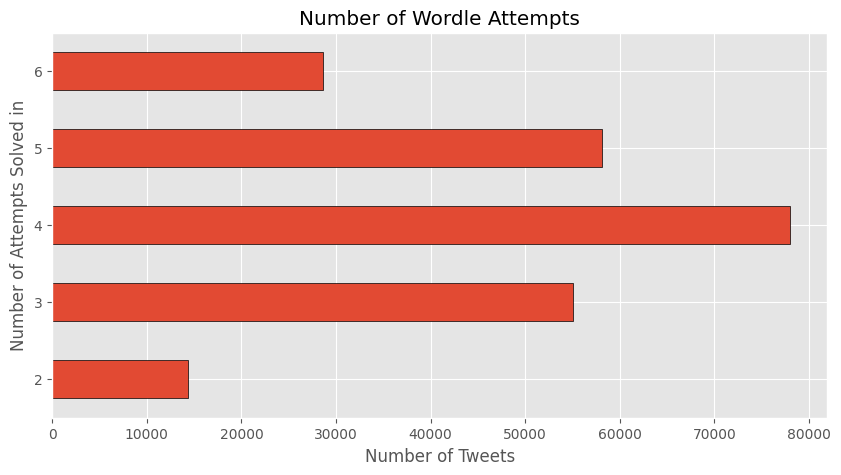

In [15]:
ax = tweets['n_attempts'].value_counts().sort_index() \
    .plot(figsize=(10,5) , kind='barh',
          title='Number of Wordle Attempts',
          edgecolor='black')

ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Attempts Solved in')
plt.show()

## Parse Tweet Text

In [19]:
# consistent dark squares
tweets['tweet_text'] = tweets['tweet_text'].str.replace('⬜', '⬛')

In [34]:
def parse_tweet_text(tweets):
    for n in range(6):
        n += 1 # number of guesses
        tweets[f'has_guess{n}']=tweets['tweet_text'].str.split('\n').str[n+1] \
            .str.contains('|'.join(['🟨','⬛','🟩'])) \
            .fillna(False)

        tweets['has_guess1'].value_counts()

        # Parse out tweet text
        tweets.loc[tweets[f'has_guess{n}'], f'guess{n}'] = \
                tweets['tweet_text'].str.split('\n').str[n+1].str[:5]

        #Count number correctly, misplaced and correct
        tweets.loc[tweets[f'has_guess{n}'], 
                        f'guess{n}_incorrect']=tweets[f'guess{n}'].str.count('⬛')
        tweets.loc[tweets[f'has_guess{n}'], 
                        f'guess{n}_wrong_spot']=tweets[f'guess{n}'].str.count('🟨')
        tweets.loc[tweets[f'has_guess{n}'], 
                        f'guess{n}_correct']=tweets[f'guess{n}'].str.count('🟩')

        tweets.loc[tweets[f'guess{n}_correct']==6,'final_guess'] = n
    return tweets

tweets = parse_tweet_text(tweets)

C:\Users\Saket Tommundrum\AppData\Local\Temp\ipykernel_22304\103052168.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
C:\Users\Saket Tommundrum\AppData\Local\Temp\ipykernel_22304\103052168.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(False)
C:\Users\Saket Tommundrum\AppData\Local\Temp\ipykernel_22304\103052168.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, s

In [37]:
# Keep additional tweet text
tweets['additional_text']= tweets.loc[~tweets['tweet_text'] \
                                      .str.split('\n').str[-1].str.contains('🟩')] \
                                      ['tweet_text'].str.split('\n').str[-1]

## Plot results by attempt

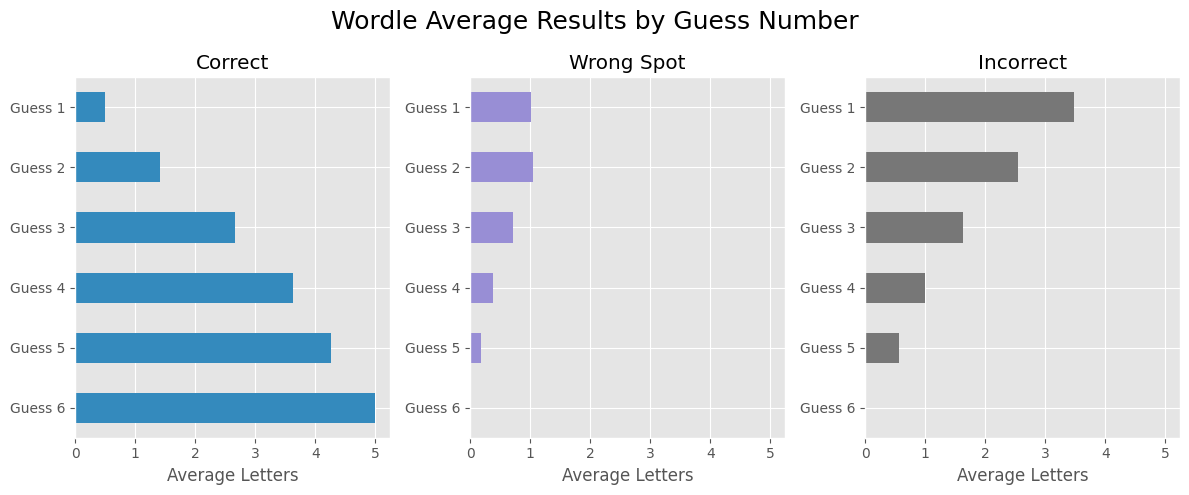

In [50]:

fig, ax=plt.subplots(1,3, figsize=(12,5), sharex=True)

for i,x in enumerate(['_correct','_wrong_spot','_incorrect']):
    col_subset = [c for c in tweets.columns if x in c]
    guess_avg = tweets[col_subset].mean()
    guess_avg.index = [f'Guess {i+1}' for i in range(6)]
    guess_avg.sort_index(ascending=False) \
        .plot(kind='barh',
              title=f'{x.strip("_").replace("_"," ").title()}',
              ax=ax[i],
              color=color_pal[i+1])
    ax[i].set_xlabel('Average Letters')

fig.suptitle('Wordle Average Results by Guess Number', fontsize=18)
plt.tight_layout()
plt.show()


In [53]:
answer_dict = {252 : 'SPILL',
     251 : 'VIVID',
     250 : 'BLOKE',
     249 : 'TROVE',
     248 : 'THORN',
     247 : 'OTHER',
     246 : 'TACIT',
     245 : 'SWILL',
     244 : 'DODGE',
     243 : 'SHAKE',
     242 : 'CAULK',
     241 : 'AROMA',
     240 : 'CYNIC',
     239 : 'ROBIN',
     238 : 'ULTRA',
     237 : 'ULCER',
     236 : 'PAUSE',
     235 : 'HUMOR',
     234 : 'FRAME',
     233 : 'ELDER',
     232 : 'SKILL',
     231 : 'ALOFT',
     230 : 'PLEAT',
     229 : 'SHARD',
     228 : 'MOIST',
     227 : 'THOSE',
     204 : 'GORGE',
     205 : 'QUERY',
     206 : 'DRINK',
     207 : 'FAVOR',
     208 : 'ABBEY',
     209 : 'TANGY',
     210 : 'PANIC',
     211 : 'SOLAR',
     212 : 'SHIRE',
     213 : 'PROXY',
     214 : 'POINT',
     215 : 'ROBOT',
     216 : 'PRICK',
     217 : 'WINCE',
     218 : 'CRIMP',
     219 : 'KNOLL',
     220 : 'SUGAR',
     221 : 'WHACK',
     222 : 'MOUNT',
     223 : 'PERKY',
     224 : 'COULD',
     225 : 'WRUNG',
     226 : 'LIGHT',
}

tweets['answer'] = tweets['wordle_id'].map(answer_dict)

In [62]:
first_guess_correct=[]
for i,d in tweets.dropna(subset=['answer']).iterrows():
    example_text=d['guess1']
    example_solution=d['answer']
    results = [x.span()[0] for x in re.finditer('🟩', example_text)]
    first_guess_letters = [example_solution[i] for i in results]
    first_guess_correct+=first_guess_letters
    



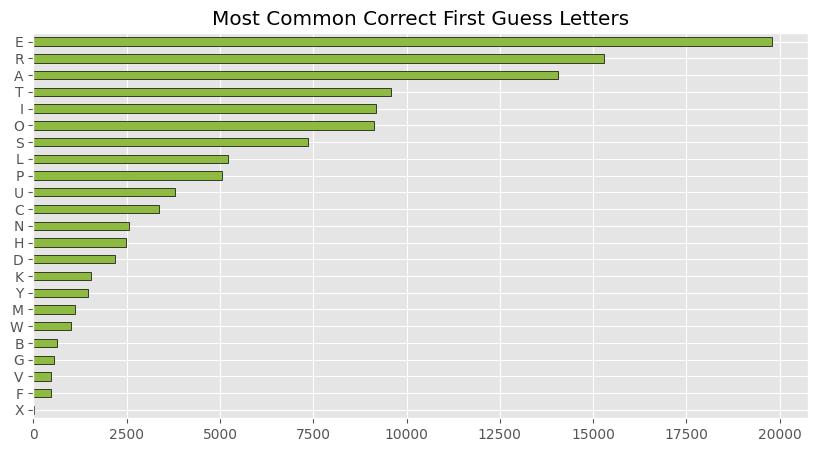

In [69]:
pd.Series(first_guess_correct).value_counts(ascending=True) \
    .plot(kind='barh', figsize=(10,5),
          title='Most Common Correct First Guess Letters',
          edgecolor='black', color=color_pal[5])
plt.show()